In [1]:
from torchvision import models
from torchvision.transforms import transforms
import torch
import CitiesData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time

In [2]:
# The inference transforms are available at ViT_B_16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
# The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. 
# Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

#models.ViT_B_16_Weights.IMAGENET1K_V1
model_name = "scratch_vit_b_16_city"
model_image_size = 224
vit = models.vit_b_16(weights=None)

In [3]:
class ViT(torch.nn.Module):
    def __init__(self, visionTransformer: models.VisionTransformer):
        super(ViT, self).__init__()
        
        self.reference_vit = visionTransformer
        self.reference_vit.heads.head = torch.nn.Linear(768, 768)
#         ViTLayers = torch.nn.Sequential(*list(visionTransformer.children())[:-1])

#         self.reference_vit.conv_proj.requires_grad = False
#         self.reference_vit.encoder.requires_grad = False
#         self.reference_vit.heads.requires_grad = False
#         self.reference_vit.heads.head.requires_grad = True
        
#         for param in self.reference_vit.parameters():
#             param.requires_grad = False

        #self.ViT = ViTLayers.to(device)
#         self.linear = torch.nn.Linear(1000, 10).to(device)
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.ReLU(),
            torch.nn.Linear(768, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512 ,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10))
        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, x):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.reference_vit.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.reference_vit.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x =  self.reference_vit.heads(x)
        
        #extractedFeature = self.ViT(x)
        x = self.layer(x)
        softmax = self.softmax(x)

        return softmax
    
    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.reference_vit.patch_size
        torch._assert(h == self.reference_vit.image_size, f"Wrong image height! Expected {self.reference_vit.image_size} but got {h}!")
        torch._assert(w == self.reference_vit.image_size, f"Wrong image width! Expected {self.reference_vit.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p
        
        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x =  self.reference_vit.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.reference_vit.hidden_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

In [4]:
visionTransformer = ViT(vit).to(device)
print(*list(visionTransformer.children())[:-1])

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [5]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(visionTransformer.parameters(), lr=1e-6)

In [6]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainDataLoader, validDataLoader, testDataLoader = CitiesData.getCitiesDataLoader("./Data/", transforms = transform, batchSize=batch_size)

In [7]:
print(len(trainDataLoader))
print(len(validDataLoader))
print(len(testDataLoader))
for i in trainDataLoader:
    image, cities, _, _ = i
    print(image.shape)
    break

6101
157
696
torch.Size([32, 3, 224, 224])


In [8]:
from fvcore.nn import FlopCountAnalysis
valid_image = 0
for i in validDataLoader:
    valid_image, cities, _, _ = i
    valid_image = valid_image.to(device)
    break
flops = FlopCountAnalysis(visionTransformer, valid_image)
print(str(flops.total()) + " flops")
# Ignore Reds

Unsupported operator aten::mul encountered 49 time(s)
Unsupported operator aten::add encountered 25 time(s)
Unsupported operator aten::div encountered 12 time(s)
Unsupported operator aten::unflatten encountered 12 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
reference_vit.encoder.layers.encoder_layer_0.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_1.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_10.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_11.self_att

539787239424 flops


In [9]:
def evaluate_on_data(vit, dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_samples = 0.0
        for data in dataloader:
            image, city, _, _ = data
            city = city.to(device)
            image = image.to(device)
            outputs = vit(image)
            loss = criterion(outputs, city)
            total_loss += loss.item()
            for i in range(len(city)):

                model_vote = 0
                answer = 0
                for j in range(len(outputs[i])):
                    if outputs[i][j] > outputs[i][model_vote]:
                        model_vote = j
                    if city[i][j] == 1:
                        answer = j
                
                if answer == model_vote:
                    num_correct += 1
                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples

In [10]:
num_epochs = 50
count = 0
valid_loss_array = []
valid_acc_array = []
train_loss_array = []
for epoch in range(num_epochs):
    start = time.time()
    batch_count = 0
    for data in trainDataLoader:
        
        image, city, _, _ = data
        
        city = city.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = visionTransformer(image)
        loss = criterion(outputs, city)
        loss.backward()
        optimizer.step()
        
        end = time.time()
        count += 1
        print(str(int(end-start)) + " sec " + str(count * batch_size) + " images " + str(loss.item()) + " loss", end='\x1b\r')
        
        batch_count += 1
        if batch_count > len(trainDataLoader) / 5.0:
            valid_loss, valid_acc = evaluate_on_data(visionTransformer, validDataLoader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}')
            valid_loss_array.append(valid_loss)
            train_loss_array.append(loss.item())
            valid_acc_array.append(valid_acc)
            batch_count = 0
            
        
    valid_loss, valid_acc = evaluate_on_data(visionTransformer, validDataLoader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}')
    valid_loss_array.append(valid_loss)
    train_loss_array.append(loss.item())
    valid_acc_array.append(valid_acc)
    

Epoch [1/50], Training Loss: 2.1405, Valid Loss: 2.1258608076324834, Valid ACC: 0.35077906512185375
Epoch [1/50], Training Loss: 1.9925, Valid Loss: 2.1017216544893245, Valid ACC: 0.35577307231322414
Epoch [1/50], Training Loss: 2.0874, Valid Loss: 2.08800528916082, Valid ACC: 0.3751498202157411
Epoch [1/50], Training Loss: 2.0179, Valid Loss: 2.06408062933506, Valid ACC: 0.39532560926887733
Epoch [1/50], Training Loss: 1.9344, Valid Loss: 2.0520255173216686, Valid ACC: 0.40391530163803435
Epoch [2/50], Training Loss: 1.9208, Valid Loss: 2.0460506046260347, Valid ACC: 0.4125049940071914
Epoch [2/50], Training Loss: 1.8995, Valid Loss: 2.0383866845619094, Valid ACC: 0.42349180982820617
Epoch [2/50], Training Loss: 2.1284, Valid Loss: 2.0340295860050643, Valid ACC: 0.426887734718338
Epoch [2/50], Training Loss: 2.0698, Valid Loss: 2.029736973701199, Valid ACC: 0.4312824610467439
Epoch [2/50], Training Loss: 2.0906, Valid Loss: 2.033624822204361, Valid ACC: 0.424690371554135
Epoch [3/50],

Epoch [17/50], Training Loss: 1.9425, Valid Loss: 1.88717644171852, Valid ACC: 0.567718737514982
Epoch [17/50], Training Loss: 1.9072, Valid Loss: 1.8863365583670908, Valid ACC: 0.5711146624051139
Epoch [18/50], Training Loss: 1.9536, Valid Loss: 1.8942410458452164, Valid ACC: 0.5617259288853376
Epoch [18/50], Training Loss: 1.7419, Valid Loss: 1.8852511116484008, Valid ACC: 0.5773072313224131
Epoch [18/50], Training Loss: 1.8503, Valid Loss: 1.884936309022129, Valid ACC: 0.5737115461446265
Epoch [18/50], Training Loss: 1.9583, Valid Loss: 1.8767107328140704, Valid ACC: 0.5848981222532961
Epoch [18/50], Training Loss: 2.0327, Valid Loss: 1.882153475113057, Valid ACC: 0.5759089093088294
Epoch [19/50], Training Loss: 1.9407, Valid Loss: 1.8810342593123632, Valid ACC: 0.5779065121853776
Epoch [19/50], Training Loss: 1.8679, Valid Loss: 1.8900802693210264, Valid ACC: 0.5683180183779465
Epoch [19/50], Training Loss: 1.7799, Valid Loss: 1.8871630651196696, Valid ACC: 0.5707151418298042
Epoch

Epoch [34/50], Training Loss: 1.8421, Valid Loss: 1.8335600493541895, Valid ACC: 0.6250499400719137
Epoch [34/50], Training Loss: 1.8346, Valid Loss: 1.826864834929104, Valid ACC: 0.6338393927287256
Epoch [34/50], Training Loss: 1.8430, Valid Loss: 1.8362032355328815, Valid ACC: 0.6210547343188174
Epoch [34/50], Training Loss: 1.8941, Valid Loss: 1.827334818448041, Valid ACC: 0.6324410707151419
Epoch [34/50], Training Loss: 1.6446, Valid Loss: 1.8296281554150626, Valid ACC: 0.6288453855373551
Epoch [35/50], Training Loss: 1.8081, Valid Loss: 1.8337107053377393, Valid ACC: 0.6254494606472233
Epoch [35/50], Training Loss: 1.8407, Valid Loss: 1.8322092554853167, Valid ACC: 0.6278465840990811
Epoch [35/50], Training Loss: 1.9317, Valid Loss: 1.8431103102510304, Valid ACC: 0.6166600079904115
Epoch [35/50], Training Loss: 1.8557, Valid Loss: 1.8314157750820224, Valid ACC: 0.6274470635237714
Epoch [35/50], Training Loss: 1.7874, Valid Loss: 1.8374131827583846, Valid ACC: 0.6202556931681982
Ep

Epoch [50/50], Training Loss: 1.8625, Valid Loss: 1.8107599174236035, Valid ACC: 0.65061925689173
Epoch [50/50], Training Loss: 1.8309, Valid Loss: 1.8200778616854991, Valid ACC: 0.6400319616460247
Epoch [50/50], Training Loss: 1.6216, Valid Loss: 1.8169545721910128, Valid ACC: 0.6404314822213344


In [11]:
with open(model_name + '_valid.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

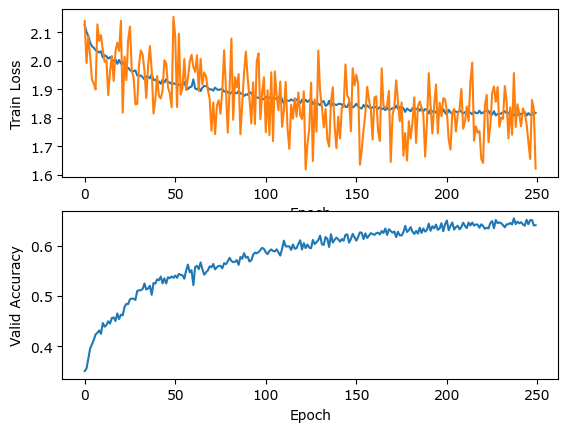

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
# this locator puts ticks at regular intervals

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Valid Cross Entropy")
ax[0].plot(range(len(valid_loss_array)), valid_loss_array)

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Valid Accuracy")
ax[1].plot(range(len(valid_acc_array)),valid_acc_array)

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Train Loss")
ax[0].plot(range(len(train_loss_array)), train_loss_array)

In [13]:
test_loss, test_acc = evaluate_on_data(visionTransformer, testDataLoader)
print(str(test_loss) + "  " + str(test_acc))

1.805983184927796  0.653002517080187


In [ ]:
num_epochs = 15
count = 0
for epoch in range(50, 50 + num_epochs):
    start = time.time()
    batch_count = 0
    for data in trainDataLoader:
        
        image, city, _, _ = data
        
        city = city.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = visionTransformer(image)
        loss = criterion(outputs, city)
        loss.backward()
        optimizer.step()
        
        end = time.time()
        count += 1
        print(str(int(end-start)) + " sec " + str(count * batch_size) + " images " + str(loss.item()) + " loss", end='\x1b\r')
        
        batch_count += 1
        if batch_count > len(trainDataLoader) / 5.0:
            valid_loss, valid_acc = evaluate_on_data(visionTransformer, validDataLoader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}')
            valid_loss_array.append(valid_loss)
            train_loss_array.append(loss.item())
            valid_acc_array.append(valid_acc)
            batch_count = 0
            
        
    valid_loss, valid_acc = evaluate_on_data(visionTransformer, validDataLoader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}')
    valid_loss_array.append(valid_loss)
    train_loss_array.append(loss.item())
    valid_acc_array.append(valid_acc)

Epoch [51/15], Training Loss: 1.7749, Valid Loss: 1.8154850621098437, Valid ACC: 0.643028365960847
Epoch [51/15], Training Loss: 1.6170, Valid Loss: 1.812093506807002, Valid ACC: 0.6454254894127047
Epoch [51/15], Training Loss: 1.8827, Valid Loss: 1.8138291082286477, Valid ACC: 0.6456252497003596
Epoch [51/15], Training Loss: 1.9349, Valid Loss: 1.802353843368651, Valid ACC: 0.6556132640831003
Epoch [51/15], Training Loss: 1.6959, Valid Loss: 1.8033169737328063, Valid ACC: 0.6550139832201358
Epoch [52/15], Training Loss: 1.8204, Valid Loss: 1.7996737173130504, Valid ACC: 0.6588094286855773
Epoch [52/15], Training Loss: 1.7369, Valid Loss: 1.8066825676604334, Valid ACC: 0.6540151817818618
